# Pipelines do it better

In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import seaborn as sns

In [205]:
tz_data = pd.read_csv('tz_data.csv')

In [206]:
data = tz_data.copy()
data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,payment_type,quality_group,quantity_group,source,waterpoint_type_group,status_group
0,69572,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,109,True,VWC,False,1999,gravity,annually,good,enough,spring,communal standpipe,2
1,8776,0.0,other,1399,other,34.698766,-2.147466,Lake Victoria,280,True,other,True,2010,gravity,never pay,good,insufficient,rainwater harvesting,communal standpipe,2
2,34310,25.0,other,686,other,37.460664,-3.821329,Pangani,250,True,VWC,True,2009,gravity,per bucket,good,enough,dam,communal standpipe,2
3,67743,0.0,other,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,VWC,True,1986,submersible,never pay,good,dry,machine dbh,communal standpipe,0
4,19728,0.0,other,0,other,31.130847,-1.825359,Lake Victoria,0,True,VWC,True,2000,gravity,never pay,good,seasonal,rainwater harvesting,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,other,1210,other,37.169807,-3.253847,Pangani,125,True,Water Board,True,1999,gravity,per bucket,good,enough,spring,communal standpipe,2
59396,27263,4700.0,other,1212,other,35.249991,-9.070629,Rufiji,56,True,VWC,True,1996,gravity,annually,good,enough,river,communal standpipe,2
59397,37057,0.0,Government Of Tanzania,0,DWE,34.017087,-8.750434,Rufiji,0,True,VWC,False,2000,handpump,monthly,fluoride,enough,machine dbh,hand pump,2
59398,31282,0.0,other,0,other,35.861315,-6.378573,Rufiji,0,True,VWC,True,2000,handpump,never pay,good,insufficient,shallow well,hand pump,2


In [207]:
data['permit'] = data['permit'].astype(int)

In [208]:
data['public_meeting'] = data['public_meeting'].astype(int)

In [209]:
data = data.drop('id', axis =1)

In [210]:
# Assuming `df` is your DataFrame
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         59400 non-null  int64  
 9   scheme_management      59400 non-null  object 
 10  permit                 59400 non-null  int64  
 11  construction_year      59400 non-null  int64  
 12  extraction_type_class  59400 non-null  object 
 13  payment_type           59400 non-null  object 
 14  quality_group          59400 non-null  object 
 15  qu

In [212]:
data[['amount_tsh', 'gps_height', 'longitude', 'population', 'public_meeting', 'status_group']].corr()

,amount_tsh,gps_height,longitude,population,public_meeting,status_group
amount_tsh,1.000000,0.076650,0.022134,0.016288,0.015798,0.053702
gps_height,0.076650,1.000000,0.149155,0.135003,0.037207,0.114029
longitude,0.022134,0.149155,1.000000,0.086590,0.016962,-0.004366
population,0.016288,0.135003,0.086590,1.000000,0.006575,0.017759
public_meeting,0.015798,0.037207,0.016962,0.006575,1.000000,0.067965
status_group,0.053702,0.114029,-0.004366,0.017759,0.067965,1.000000


<Axes: >

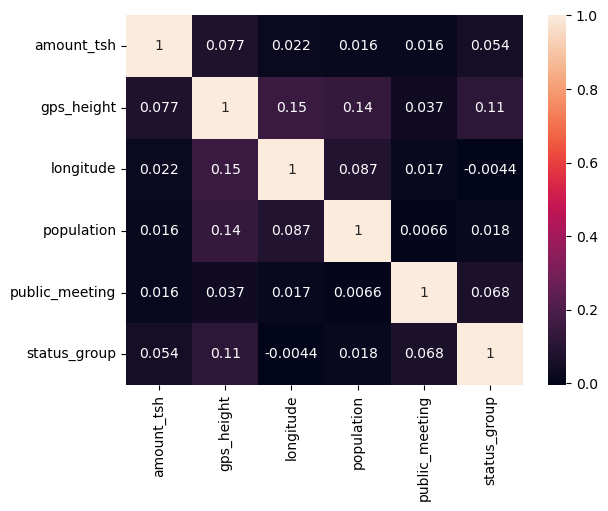

In [213]:
sns.heatmap(data[['amount_tsh', 'gps_height', 'longitude', 'population', 'public_meeting', 'status_group']].corr(),annot=True)

In [214]:
data['status_group'].value_counts()

status_group
2    32259
0    22824
1     4317
Name: count, dtype: int64

In [215]:
target_status = {0: 0, 1: 1, 2 : 2}
data['status_group'] = data['status_group'].replace(target_status)

In [216]:
X = data.drop('status_group', axis=1)  
y = data['status_group'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [217]:
cat_cols = ['funder', 'installer', 'basin', 'scheme_management', 'extraction_type_class', 'payment_type', 'quality_group', 
              'quantity_group', 'source', 'waterpoint_type_group']

num_cols = ['amount_tsh', 'gps_height', 'longitude', 'population', 'public_meeting']

In [218]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [219]:
CT = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])

In [220]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000))
])

In [237]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None]
}

In [238]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['funder',
                                                                          'installer',
                                                                          'basin',
                                                                          'scheme_management',
                                                                          'extraction_type_class',
                                                                          'payment_type',
                                                                          'quality_group',
                                                                          'quantity_group',
                                                                          'source',
                                                                          'waterpoint_type_group']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'longitude',
                                                                          'population',
                                                                          'public_meeting'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           multi_class='multinomial'))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 None]})

In [223]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [224]:
y_pred = best_model.predict(X_test)
np.unique(y_pred)

array([0, 1, 2])

In [225]:
import numpy as np

unique_values = np.unique(y_train)
print(unique_values)

[0 1 2]


In [226]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7244158759310274

In [227]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7237800894517312
Test Accuracy: 0.7244158759310274

Balanced Accuracy:
Train Accuracy: 0.5106124325917278
Test Accuracy: 0.5112115940556069


In [232]:
data_results = pd.DataFrame(columns=["Model", "test_balanced_acc",
                                   'train_balanced_acc', 'info'])

In [236]:
new_row = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.510], 
       'train_balanced_acc' : [0.511],
               'info' : ['gridsearch best param']})
data_results = pd.concat([data_results, new_row], ignore_index =True)

In [229]:
import sklearn
print(sklearn.__version__)

1.3.1


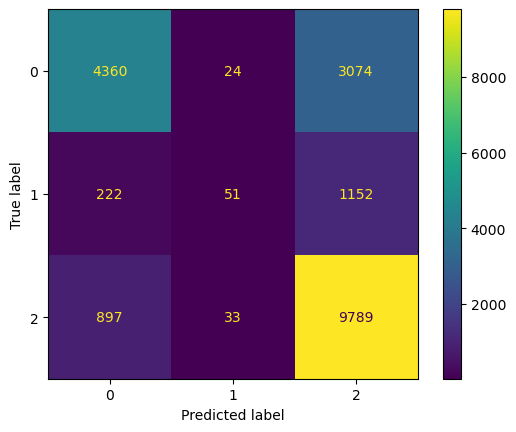

In [230]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Logistic regression
>- model performed well on training and not so we